# Descrição

Esse notebook tem o objetivo de construir algumas plotagens para a apresentação final do Trainee da UFFinnace. Refletindo algumas teses de investimentos que seguimos durante alocação de da carteira.

# Bibliotecas

As bibliotecas carregadas serão usadas para construir os objetos que o Grupo Alpha utilizou na apresentação final.

In [1]:
# Fontes dos Dados
from bcb import sgs
import yfinance as yf

# Manipular Dados
import pandas as pd
import numpy as np

# Ferramentas Facilitadoras
from tqdm import tqdm
import datetime
from IPython.display import clear_output

# Apresentação de Dados
import matplotlib.pyplot as plt
import seaborn as sns

# Entradas

A decisão final será utlizada para o BackTest e para a matriz de correlação, seguindo a decisão em conjunto com o grupo da diversificação do portfólio. 

In [2]:
# Opções das aos grupos do Treinee
acoesBrTreinee = pd.read_csv('AT_BR.txt')
ETFsTreinee = pd.read_csv('AT_ETF.txt')

acoesBrTreinee = list(acoesBrTreinee['AT_BR'].values)
ETFsTreinee = list(ETFsTreinee['AT_EXTR'].values)

listagemTreinee = ['^BVSP', 'CDI'] + acoesBrTreinee + ETFsTreinee

In [3]:
# Esse vai ser o conjunto do Backtest
alocacaoFinal = {
    'ALUP11.SA': 0.04,
    'BBAS3.SA': 0.03,
    'BCSA34.SA': 0.01,
    'EMBR3.SA': 0.04,
    'ITSA4.SA': 0.015,
    'ITUB4.SA': 0.015,
    'NUTR3.SA': 0.03,
    'ROXO34.SA': 0.03,
    'TAEE11.SA': 0.02,
    'VALE3.SA': 0.02,
    'SPY': 0.12,
    'XLF': 0.08,
    'XLK': 0.18,
    'TLT': 0.12,
    'CDI': 0.25
}

# Dados de Entrada do Backtest
inicioBacktest = '2021-07-14'
fimBacktest = '2024-07-14'

# Funções

Essas são as funções que vou chamar durante o código.

In [4]:
# Para transformar um vetor de valores em variações a partir de uma data início
def retornoDiario(vetor):
    '''
    Essa função é usada para calcular a variação dos ativos a partir do dia 0.
    Tenho uma condição para a Nubank porque esse ativo começa a ser negociado na nossa base a partir de 07/08/2023.
    '''
    labor = vetor.columns[0]
    
    dfRetorno = pd.DataFrame()

    if labor == 'ROXO34.SA':
        dfRetorno[labor] = (vetor/vetor.iloc[534])-1
        dfRetorno[labor].iloc[:534] = np.nan
    else:
        dfRetorno[labor] = (vetor/vetor.iloc[0])-1
    
    return dfRetorno

In [6]:
# Definir cálculo financeiro para os montantes do ativo CDI
def vetorCDI(taxas, valorInicial=1000):
    '''
    Essa função pega o código do BACEN referente a taxa de juros diária e retorna um vetor de valores que considera um
    ativo que rende 100% do CDI diário. Basicamente é o ativo livre de risco da dinâmica, validei ele pela CALC da B3,
    o vetor confere com essa premissa.
    '''
    datasIndex = taxas.index
    
    taxas = list(taxas['CDI'])
    taxas = [0] + taxas[:-1]

    montantesCDI = []

    for i, taxa in enumerate(taxas):
        # Setar C inicial
        if i == 0:
            montanteAnterior = valorInicial

        # Fazendo o cálculo financeiro diário
        montanteDia = montanteAnterior*(taxa/100 + 1)

        # Setar C para o próx loop 
        montanteAnterior = montanteDia

        # Construir vetor de valores
        montantesCDI.append(montanteDia)

    montantesCDI = pd.DataFrame({'CDI': montantesCDI})
    montantesCDI.index = datasIndex

    return montantesCDI

# Dados do Ativo de Renda Fixa

In [7]:
# Utilização do código 12 SGS Bacen, - Taxa de juros(CDI) -, unidade % a.d.
taxaCDI = sgs.get({'CDI': 12}, start = inicioBacktest)

taxaCDI = taxaCDI.iloc[:753] # Delimitando para o dia  12/07/2024.

ativoCDI = vetorCDI(taxaCDI, 1000)

retornoCDI = retornoDiario(ativoCDI)

### Validando Ativo CDI

Vou provar que o código tá calculando corretamente um ativo CDI rendendo 100% da taxa diária. Veja que bate com o CALC da B3.

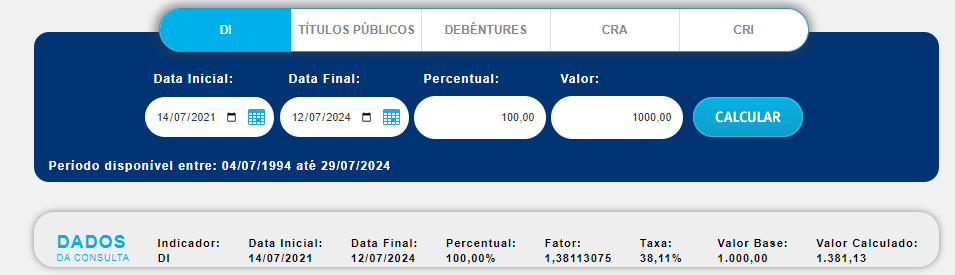

In [6]:
print('Valor calculado do dia de saque:')
display(ativoCDI.iloc[-1:])
print('Valor da taxa de retorno do ativo rendendo 3 anos:')
display(retornoCDI.iloc[-1:])

Valor calculado do dia de saque:


,CDI
Date,
2024-07-12,1381.130754


Valor da taxa de retorno do ativo rendendo 3 anos:


,CDI
Date,
2024-07-12,0.381131


# Puxando os Retornos os 3 Anos dos Ativos

In [15]:
# Ativos selecionados
ativos = list(alocacaoFinal.keys())
ativos = ['^BVSP'] + list(alocacaoFinal.keys())

# Data Frame de valores diários da seleção dos dados
dfAcoes = yf.download(ativos, start = inicioBacktest, end = fimBacktest)['Adj Close']

# Limpa saídas desnecessárias
clear_output()

## Base de Dados de Retorno Acumulado para o BackTest

In [22]:
# Transformando em Retornos diários
retornoBackTest = pd.DataFrame()

# Retirando descasamento das ações
dfAcoes = dfAcoes.dropna(subset=['SPY', '^BVSP'])

for ativo in ativos:
    df = pd.DataFrame(dfAcoes[ativo])
    df = retornoDiario(df)
    retornoBackTest[ativo] = df

# Adicionando o vetor de retornos do ativo livre de risco a minha base
retornoBackTest['CDI'] = retornoCDI['CDI']

clear_output()

## Base de Dados de Retornos Diários para a Matriz de Correlação

In [32]:
dfAcoes['CDI'] = ativoCDI

retornoDiarios = pd.DataFrame()

for col in dfAcoes.columns:
    retornoDiarios[col] = dfAcoes[[col]].shift(-1)/dfAcoes[[col]]-1
    retornoDiarios[col] = retornoDiarios[col].replace(-1, 0)

### Reorganizado o DataFrame de Retornos Diários

Antes gostaria de reorganizar as colunas dos meus ativos para melhorar a visualização da Matriz de Correlação.

In [34]:
ordem = ['CDI', # Ativo CDI no topo
         'TLT', 'SPY', 'XLF', 'XLK', # Logo após os ETF's escolhidos
         'ITSA4.SA', 'ITUB4.SA', 'BBAS3.SA', 'BCSA34.SA', # Escolhas Brasil: Bancos,
         'ALUP11.SA', 'TAEE11.SA', 'VALE3.SA', 'EMBR3.SA', # Transmissores, Mineração, Aviação 
         'NUTR3.SA', 'ROXO34.SA', # Tecnologia: Agrotech & Fintech
         '^BVSP'] # Índice da Bolsa Brasileira

retornoDiarios = retornoDiarios.reindex(columns=ordem)

# Matriz de Correlação

A matriz de correlação dos ativos foi utilizada na apresentação, é um instrumento importante e poderoso para conceituar a diversificação de portfólio.


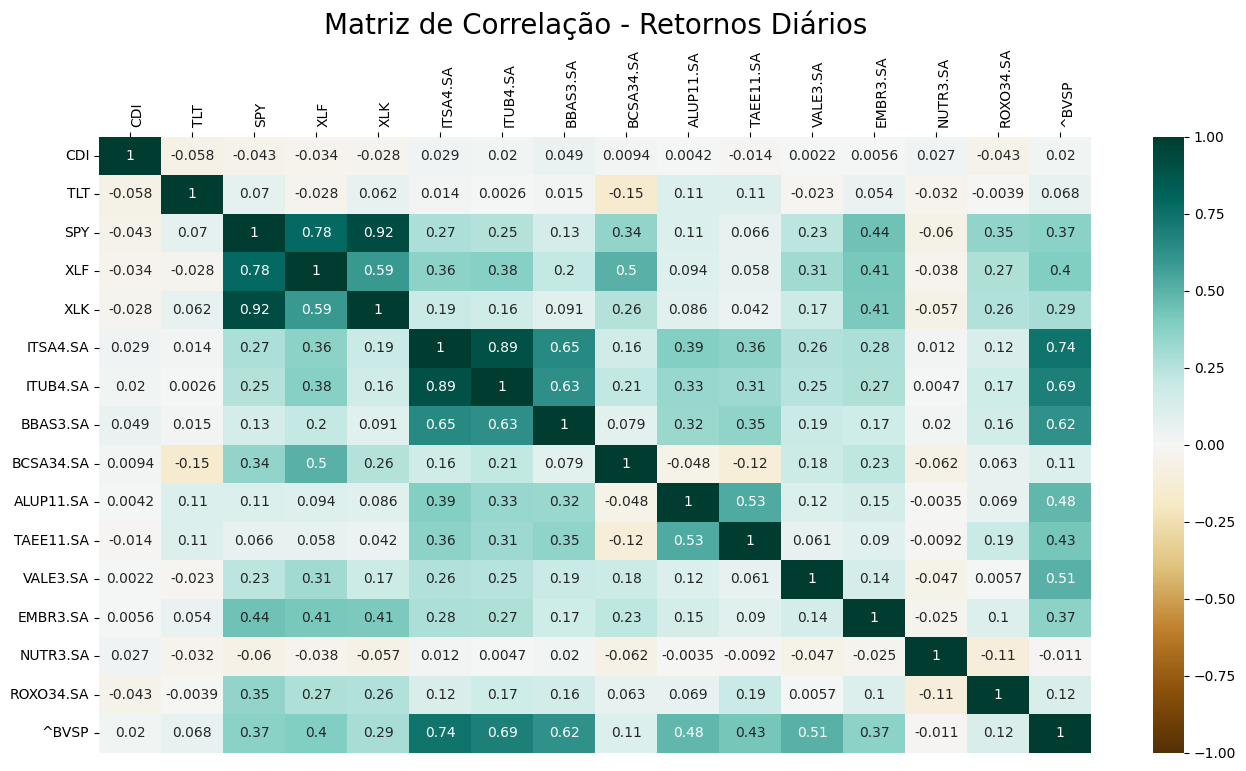

In [35]:
plt.figure(figsize = (16, 8))

matrizFinal = sns.heatmap(retornoDiarios.corr(method='spearman'),
                            vmin = -1, vmax = 1,
                            annot = True, cmap = 'BrBG')

matrizFinal.xaxis.set_ticks_position('top')
matrizFinal.xaxis.set_label_position('top')
plt.xticks(rotation=90, ha='left')

matrizFinal.set_title('Matriz de Correlação - Retornos Diários',
                      fontsize=20,pad=10)

clear_output()

# BackTest do Portfólio

Backtests são usados para avaliar o desempenho de um ativo ao longo de determinado tempo. No nosso caso, reolvemos multiplicar os retornos diários para compor um portfólio com o ativo livre de risco, o S&P 500 e a bolsa brasileira nos últimos 3 anos. Assim, podemos ver uma tendência de rompimento que demonstra o motivo de termos alocado tanto dos nossos recursos no final da dinâmica.

In [36]:
# Proposta 1: Acompanhar o somatório de retornos diários incidindo em um patrimônio
Carteira = pd.DataFrame()

for ativo in alocacaoFinal.keys():
    dfAtivo = retornoDiarios[ativo].fillna(0)
    Carteira[ativo] = dfAtivo * alocacaoFinal[ativo]

Carteira['Carteira'] = Carteira.sum(axis=1)

Carteira['CDI'] = retornoDiarios['CDI']
Carteira['^BVSP'] = retornoDiarios['^BVSP']
Carteira['SPY'] = retornoDiarios['SPY']

Carteira = Carteira.shift(1)
Carteira.iloc[0] = 1

# Construir objetos de teste

objBackTest = ['Carteira', 'CDI', '^BVSP', 'SPY']
for i in objBackTest:
    Carteira[i] = Carteira[i].cumsum()

Carteira = Carteira[objBackTest]

In [37]:
# Proposta 2: Avaliar rentabilidade da data 0 até 3 anos depois.
Portfolio = pd.DataFrame()

for ativo in alocacaoFinal.keys():
    dfAtivo = retornoBackTest[ativo].fillna(0)
    Portfolio[ativo] = dfAtivo * alocacaoFinal[ativo]

Portfolio['Portfólio'] = Portfolio.sum(axis=1)

BackTest = retornoBackTest[['CDI', '^BVSP', 'SPY']]
BackTest['Portfólio'] = Portfolio[['Portfólio']]

clear_output()

Considerações acerca dos dois modelos:

### BackTest Utilizado na Apresentação

Deixo nesse código dois modelos, um que é basicamente uma soma acumulada dos retornos diários e outro mais adiante que acredito ser mais correto.

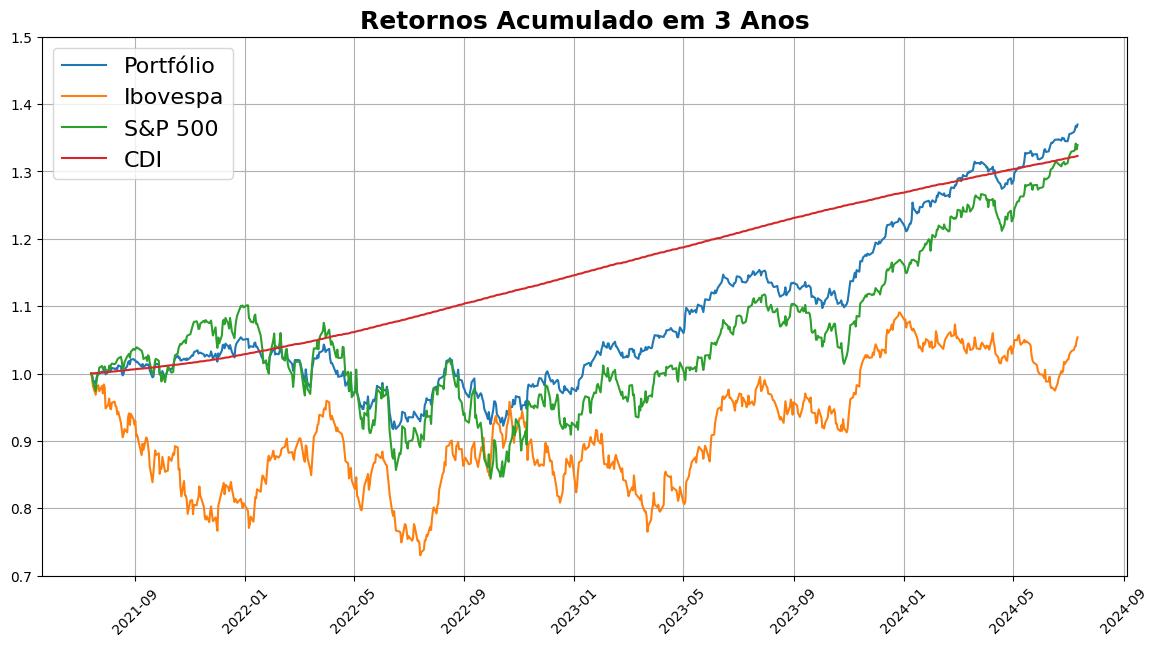

In [39]:
# Plotar o gráfico de linhas
plt.figure(figsize=(14, 7))
plt.plot(Carteira.index, Carteira['Carteira'], label='Portfólio')
plt.plot(Carteira.index, Carteira['^BVSP'], label='Ibovespa')
plt.plot(Carteira.index, Carteira['SPY'], label='S&P 500')
plt.plot(Carteira.index, Carteira['CDI'], label='CDI')

# Configurações do gráfico
plt.title('Retornos Acumulado em 3 Anos', fontsize=18, weight="bold")
plt.xlabel('')
plt.ylabel('')
plt.ylim(0.7, 1.5)
plt.legend(fontsize=16)
plt.grid(True)
plt.xticks(rotation=45)

# Mostrar o gráfico
plt.show()

### Outra Proposta de Backtest

Este segundo acredito ter mais fundamento, basicamente ele pega o valor do ativo no dia 0 e vai acompanhando seu preço durante esses 3 anos.

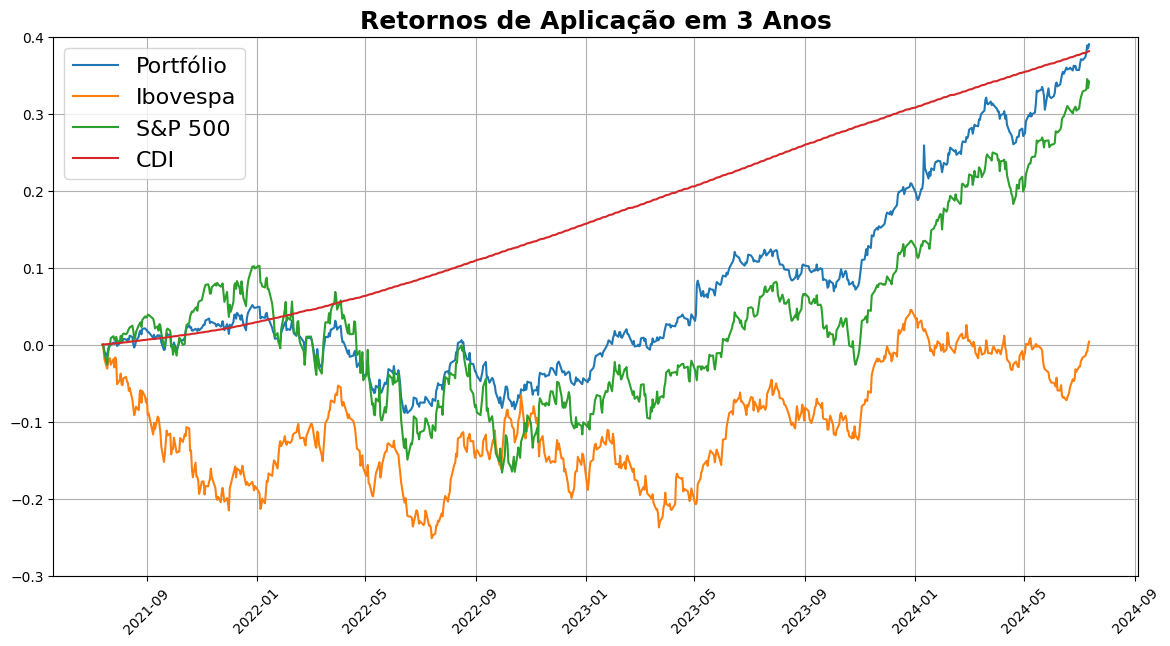

In [42]:
# Plotar o gráfico de linhas
plt.figure(figsize=(14, 7))
plt.plot(BackTest.index, BackTest['Portfólio'], label='Portfólio')
plt.plot(BackTest.index, BackTest['^BVSP'], label='Ibovespa')
plt.plot(BackTest.index, BackTest['SPY'], label='S&P 500')
plt.plot(BackTest.index, BackTest['CDI'], label='CDI')

# Configurações do gráfico
plt.title('Retornos de Aplicação em 3 Anos', fontsize=18, weight="bold")
plt.xlabel('')
plt.ylabel('')
plt.ylim(-0.3, 0.4)
plt.legend(fontsize=16)
plt.grid(True)
plt.xticks(rotation=45)

# Mostrar o gráfico
plt.show()

# Outros Gráficos Usados na Apresentação

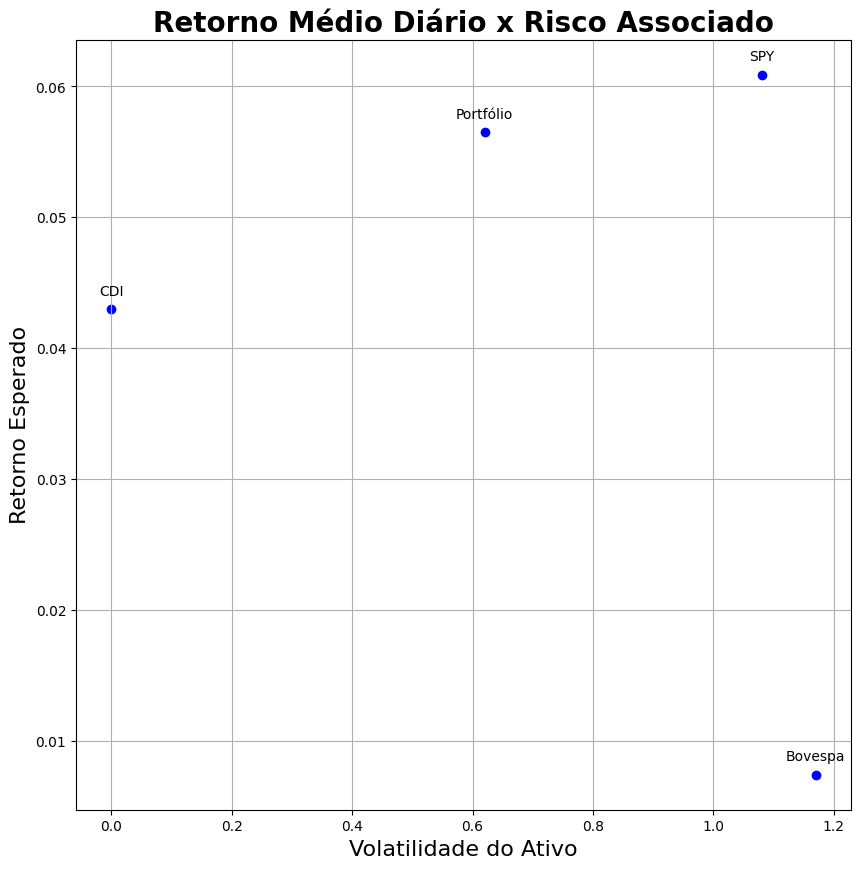

In [44]:
# Dados
dados = {
    "Objeto do Teste": ["Portfólio", "Bovespa", "SPY", "CDI"],
    "Retorno Esperado": [0.0565, 0.0074, 0.0609, 0.0430],
    "Risco": [0.62, 1.17, 1.08, 0.00]
}

# Criando o gráfico
plt.figure(figsize=(10, 10))
plt.scatter(dados["Risco"], dados["Retorno Esperado"], color='blue')

# Adicionando anotações
for i, label in enumerate(dados["Objeto do Teste"]):
    plt.annotate(label, (dados["Risco"][i], dados["Retorno Esperado"][i]),
                 textcoords="offset points", xytext=(0,10), ha='center')

# Configurações do gráfico
plt.title('Retorno Médio Diário x Risco Associado', fontsize=20, weight='bold')
plt.xlabel('Volatilidade do Ativo', fontsize=16)
plt.ylabel('Retorno Esperado', fontsize=16)
plt.grid(True)

# Mostrar o gráfico
plt.show()

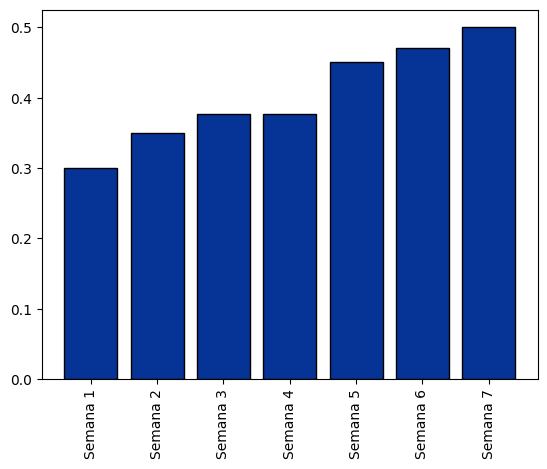

In [25]:
# Histograma com alocação de Exchange-Trade Funds até a última semana
pesos = [0.3, 0.35, 0.3775, 0.3775, 0.45, 0.47, 0.5]
semanas = ['Semana 1', 'Semana 2', 'Semana 3', 'Semana 4', 'Semana 5', 'Semana 6', 'Semana 7']

plt.bar(semanas, pesos,
        color = (0.02, 0.20, 0.59), # Cor padrão rgb da UFFinance
        edgecolor='black') # borda

plt.xticks(semanas, # Colocando legenda
           rotation=90)  # Rotacionando

plt.show()

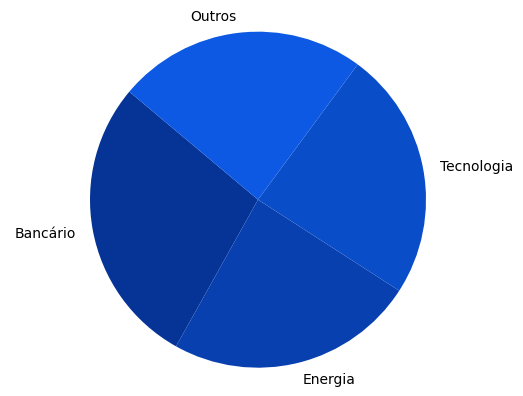

In [47]:
# Alocação última dos Ativos da Carteira Brasil
pesos = [7, 6, 6, 6]
labels = ['Bancário', 'Energia', 'Tecnologia', 'Outros']

paleta = [
    (0.02, 0.20, 0.59),
    (0.03, 0.25, 0.69),
    (0.04, 0.30, 0.79),
    (0.05, 0.35, 0.89)
]

plt.pie(pesos, labels=labels,
        colors=paleta,
        startangle=140)

plt.axis('equal')
plt.show()

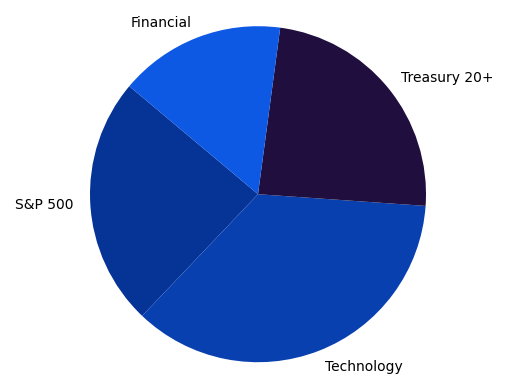

In [45]:
# Alocação última dos Exchange-Trade Funds
sizes = [12, 18, 12, 8]
labels = ['S&P 500', 'Technology', 'Treasury 20+', 'Financial']

paleta = [
    (0.02, 0.20, 0.59),
    (0.03, 0.25, 0.69),
    (0.121, 0.054, 0.242),
    (0.05, 0.35, 0.89)
]

plt.pie(sizes, labels=labels,
        colors=paleta,
        startangle=140)

plt.axis('equal')
plt.show()